In [28]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import tifffile 
import pickle

# from keras.utils import to_categorical
# from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
# from keras.models import Sequential
# from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from skimage.transform import resize

np.random.seed(1)

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC

import skimage 
from skimage import data, segmentation, feature, future

from functools import partial

In [5]:
train_images = [] 
train_labels = [] 
shape = (512, 512)

train_path = '../data/Training/'

for root, dirs, files in os.walk(train_path):
    for f in files:
        if f.endswith(".tif"):
            filepath = os.path.join(root, f)
            classlabel = os.path.basename(Path(filepath).parents[1])
            
#             print(classlabel)
#             print(filepath)
            img = tifffile.imread(filepath)
            image_reshaped = resize(img, shape, preserve_range=True)
            
            train_images.append(image_reshaped)
            train_labels.append(classlabel)    

### Training with just pixel information - no feature extraction 

In [6]:
# for fitting model, we need X array of shape (n samples, n features)
# for pixel info we just use all pixel values as features
x_images = np.array([img.flatten() for img in train_images])
x_labels = np.array(train_labels)

In [7]:
# checking array shapes 
print(np.array(train_images).shape)
print(np.array(train_labels).shape)
print(x_images.shape)
print(x_labels.shape)
print(train_labels)

(48, 512, 512)
(48,)
(48, 262144)
(48,)
['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'droplet', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates', 'aggregates']


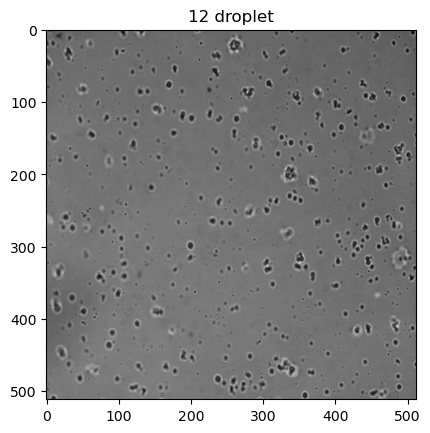

In [10]:
# Visualizing Training data
idx = np.random.randint(0, len(train_images))
plt.imshow(train_images[idx], cmap="gray")
plt.title(str(idx) + " " + train_labels[idx])
plt.show()

In [11]:
# split data into training and evaluation set
x_train, x_test, y_train, y_test = train_test_split(x_images, x_labels, test_size=0.2, random_state=0)

# train model with randomforestclassifer
clf_rfc = RandomForestClassifier().fit(x_train, y_train)

# evaluate the model with test data
y_pred_rfc = clf_rfc.predict(x_test)

print(precision_score(y_test, y_pred_rfc, average='weighted'))
print(accuracy_score(y_test, y_pred_rfc)) 

0.8571428571428571
0.8


In [12]:
print(x_test.shape)
for image, prediction in zip(x_test, y_pred_rfc):
    image = image.reshape(512, 512)
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Prediction: {prediction}')

(10, 262144)


### Let us extract some features in the images 

In [13]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max)

In [14]:
print(skimage.__version__)

0.18.2


In [15]:
x_features = []

for img in train_images:
    feature = features_func(img)
#     print(feature.shape)
    x_features.append(feature.flatten())

In [16]:
print(np.array(x_features).shape)
print(x_labels.shape)

x_features = np.array(x_features)

(48, 3932160)
(48,)


In [17]:
# split data into training and evaluation set
x_train_feature, x_test_feature, y_train_feature, y_test_feature = train_test_split(x_features, x_labels, test_size=0.2, random_state=0)


# train model with randomforestclassifer
clf_feature = RandomForestClassifier().fit(x_train_feature, y_train_feature)

# evaluate the model with test data
y_pred_feature = clf_feature.predict(x_test_feature)

In [18]:
print(precision_score(y_test_feature, y_pred_feature, average='weighted'))
print(accuracy_score(y_test_feature, y_pred_feature)) 
print(confusion_matrix(y_test_feature, y_pred_feature)) 
print(f1_score(y_test_feature, y_pred_feature, average='weighted', labels=np.unique(y_pred_feature)))

1.0
1.0
[[2 0 0]
 [0 5 0]
 [0 0 3]]
1.0


In [19]:
print(x_test_feature.shape)
for image, prediction in zip(x_test_feature, y_pred_feature):
    image = image.reshape(512, 512, 15)
    image = image[:, :, 0]
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Prediction: {prediction}')

(10, 3932160)


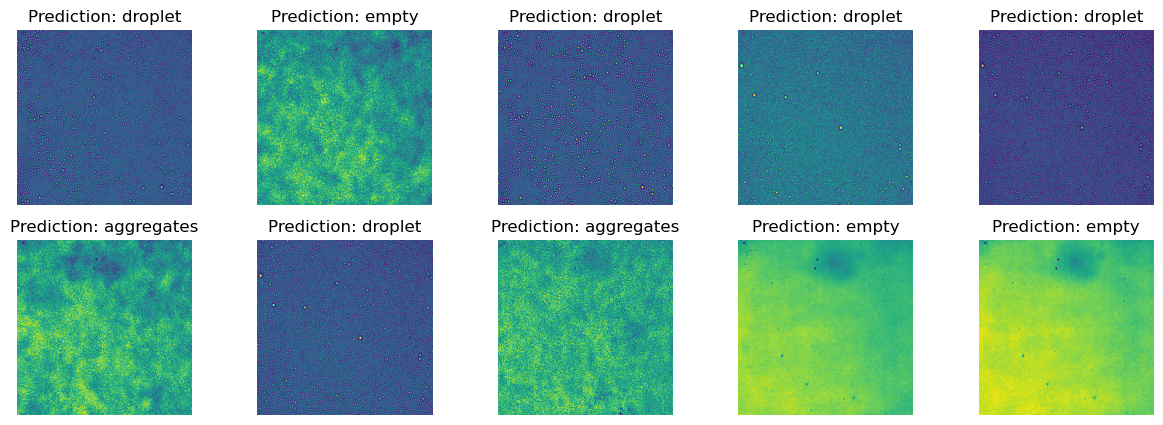

In [22]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for ax, image, prediction in zip(axes.flatten(), x_test_feature, y_pred_feature):
#   printrint(ax[0])
    ax.set_axis_off()
    image = image.reshape(512, 512, 15)
    image = image[:, :, 0]
    ax.imshow(image, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

plt.show()

In [27]:
savedir = os.path.join(os.path.dirname(os.path.dirname(train_path)), "classifierfile") 
if not os.path.exists(savedir):
    os.makedirs(savedir)

../data/classifierfile


In [29]:
# save the classifier
with open(os.path.join(savedir, 'classifier_small.pkl'), 'wb') as fid:
    pickle.dump(clf_feature, fid)    

In [30]:
# load it again
with open(os.path.join(savedir, 'classifier_small.pkl'), 'rb') as fid:
    myclassifier = pickle.load(fid)

In [31]:
y_pred_feature_test = myclassifier.predict(x_test_feature)

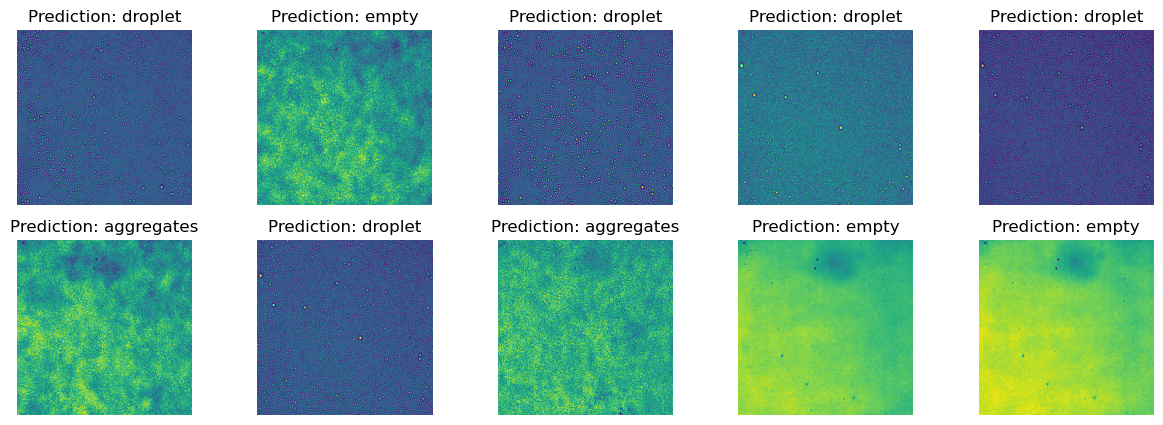

In [32]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for ax, image, prediction in zip(axes.flatten(), x_test_feature, y_pred_feature_test):
#   printrint(ax[0])
    ax.set_axis_off()
    image = image.reshape(512, 512, 15)
    image = image[:, :, 0]
    ax.imshow(image, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

plt.show()